## Forecasting Household Energy Consumption

In [39]:
# Importing Libraries
import config as config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly as py #pip install plotly
import plotly.graph_objs as go
from scipy import stats
from prophet import Prophet #pip install fbprophet
import warnings
import chart_studio as tls
warnings.filterwarnings('ignore')
tls.tools.set_credentials_file(username="root", api_key="root")
print("Libraries Imported")

Libraries Imported


In [40]:
# Import dataset
#Import data file
path = 'household_power_consumption.txt'

dtypes = {'Date': str,
          'Time': str,
          'Global_active_power': float,
          'Global_reactive_power': float,
          'Voltage': float,
          'Global_intensity': float,
          'Sub_metering_1': float,
          'Sub_metering_2': float,
          'Sub_metering_3': float}

#Deal with missing values
energy = pd.read_csv(path, sep=';',dtype=dtypes, na_values="?")
energy = energy.fillna(method='ffill')
energy.head(10)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
5,16/12/2006,17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0
6,16/12/2006,17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0
7,16/12/2006,17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0
8,16/12/2006,17:32:00,3.668,0.510,233.99,15.8,0.0,1.0,17.0
9,16/12/2006,17:33:00,3.662,0.510,233.86,15.8,0.0,2.0,16.0


In [41]:
#Insert additional columns
energy.insert(0, 'Date_Time', pd.to_datetime(energy['Date'] + ' ' + energy['Time'])) #datetime format
energy.insert(2, 'Year',energy['Date_Time'].dt.year) #year
energy.insert(3, 'Month',energy['Date_Time'].dt.month) #month
energy.insert(4, 'Day',energy['Date_Time'].dt.weekday) #weekday_name
energy.insert(5, 'Hour',energy['Date_Time'].dt.hour) #hour

#Exclude other numerical variables
energy = energy.iloc[:,0:8]

#Preview data
energy.head()

,Date_Time,Date,Year,Month,Day,Hour,Time,Global_active_power
0,2006-12-16 17:24:00,16/12/2006,2006,12,5,17,17:24:00,4.216
1,2006-12-16 17:25:00,16/12/2006,2006,12,5,17,17:25:00,5.360
2,2006-12-16 17:26:00,16/12/2006,2006,12,5,17,17:26:00,5.374
3,2006-12-16 17:27:00,16/12/2006,2006,12,5,17,17:27:00,5.388
4,2006-12-16 17:28:00,16/12/2006,2006,12,5,17,17:28:00,3.666


## Analyze and Visualize Series

In [42]:
np.round(energy['Global_active_power'].describe(), 2).apply(lambda x: format(x, 'f'))

count    2075259.000000
mean           1.090000
std            1.050000
min            0.080000
25%            0.310000
50%            0.600000
75%            1.520000
max           11.120000
Name: Global_active_power, dtype: object

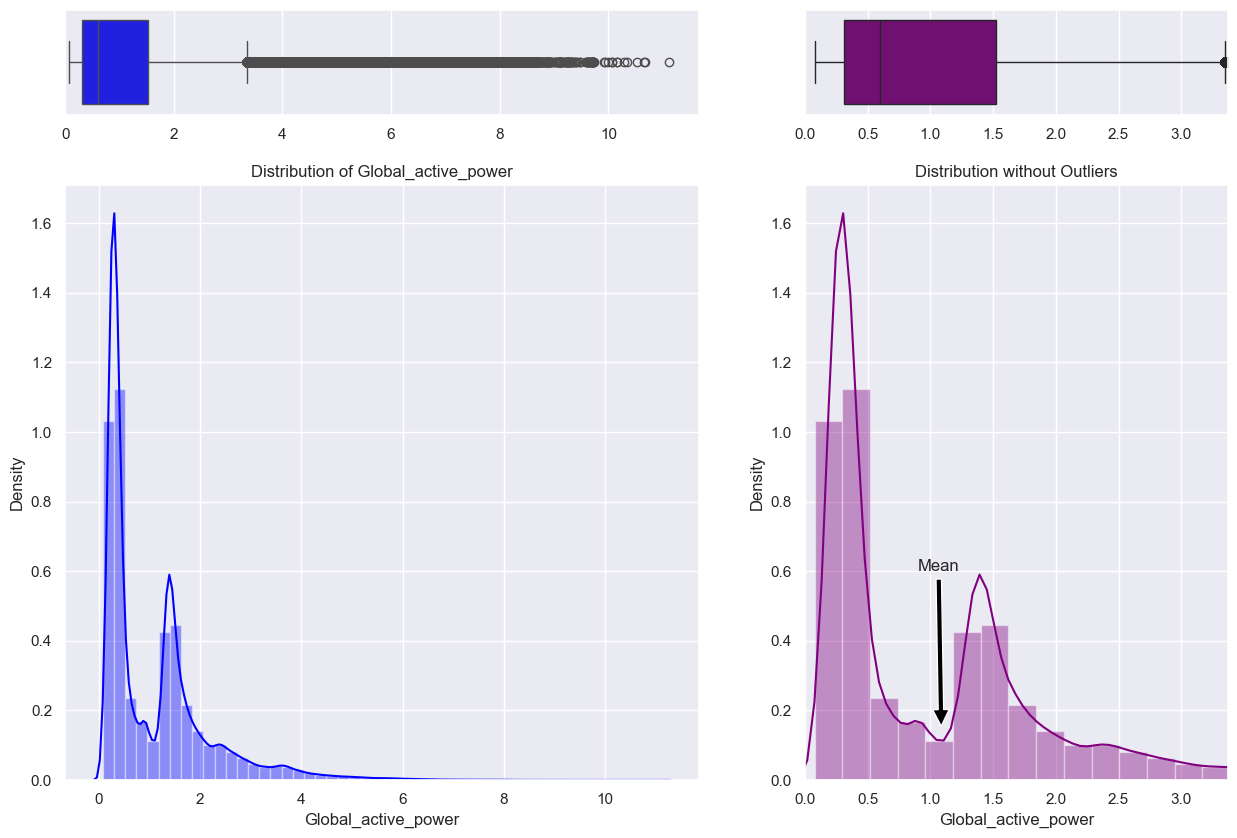

In [43]:
# Create subplots
f, axes = plt.subplots(2,
                       2, 
                       figsize=(15, 10), 
                       sharex=False, 
                       gridspec_kw={"height_ratios": (.15, .85),"width_ratios":(.60,.40)})
#Main boxplot
sns.boxplot(energy["Global_active_power"] , color="blue", ax=axes[0,0],orient="h")
axes[0,0].set_xlabel('')
axes[0,0].set_xlim(0, None)

#Main distribution
sns.distplot(energy["Global_active_power"] , color="blue", ax=axes[1,0])
axes[0,0].set_xlim(0, None)
axes[1,0].set_title('Distribution of Global_active_power')

#Zoom boxplot
sns.boxplot(energy["Global_active_power"], color="purple", ax=axes[0,1],orient="h")
axes[0,1].set_xlabel('')
axes[0,1].set_xlim(0, 3.37)

#Zoom distribution
sns.distplot(energy["Global_active_power"], color="purple", ax=axes[1,1])
axes[1,1].set_title('Distribution without Outliers')
axes[1,1].set_xlim(0, 3.37)

# Add an arrow to mark the mean value
axes[1,1].annotate(
'Mean', xy=(energy["Global_active_power"].mean(), .15), xytext=(.9, .6),
arrowprops=dict(facecolor='black', shrink=0.01))

plt.show()

# Line Plot

<Axes: xlabel='Date', ylabel='Global_active_power'>

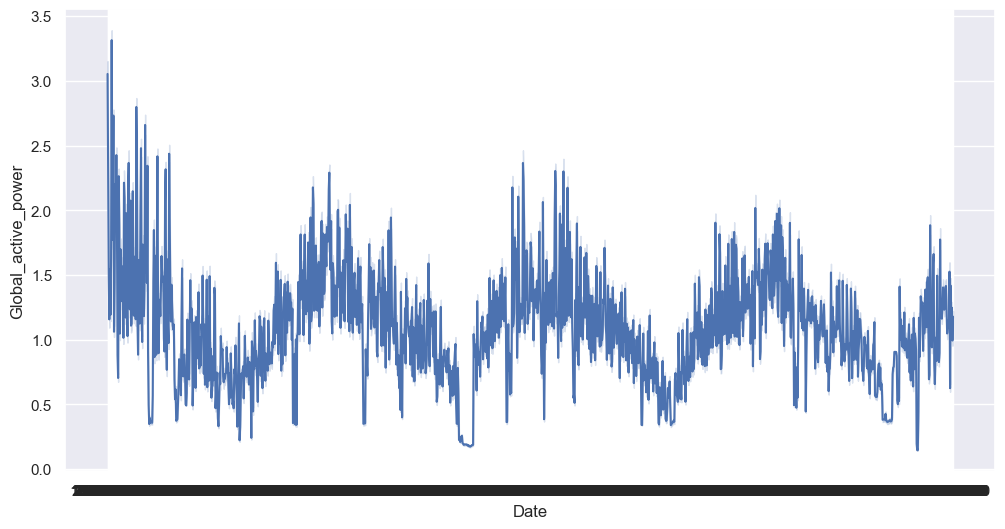

In [44]:
plt.figure(figsize=(12, 6)) 
sns.lineplot(x='Date', y='Global_active_power', data=energy)

# Line Plot for Individual Years

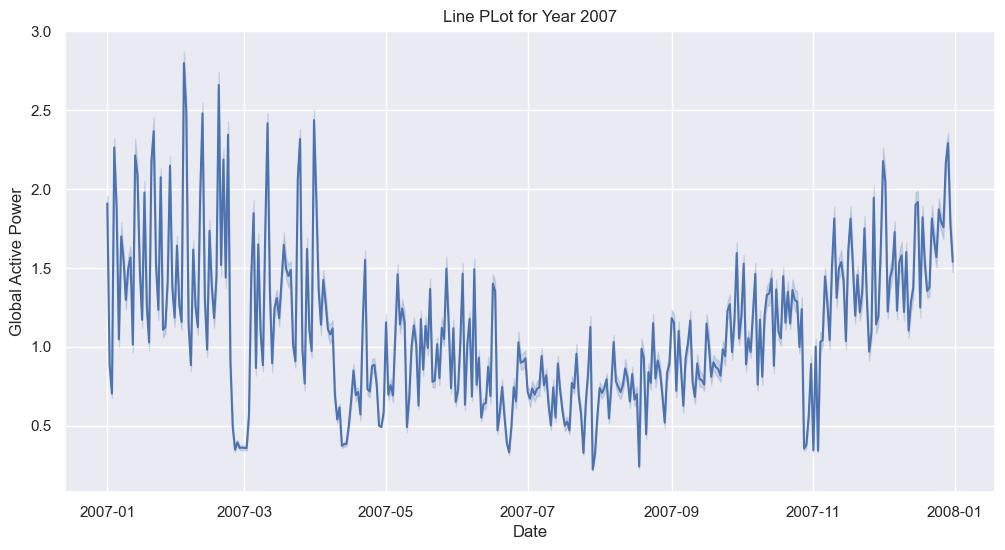

In [45]:
energy['Date'] = pd.to_datetime(energy['Date'], format='%d/%m/%Y')
plt.figure(figsize=(12, 6)) 
filtered_data = energy[(energy['Date'].dt.year == 2007)]
sns.set(style="darkgrid")
sns.lineplot(x='Date', y='Global_active_power', data=filtered_data)
plt.title('Line PLot for Year 2007')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.show()

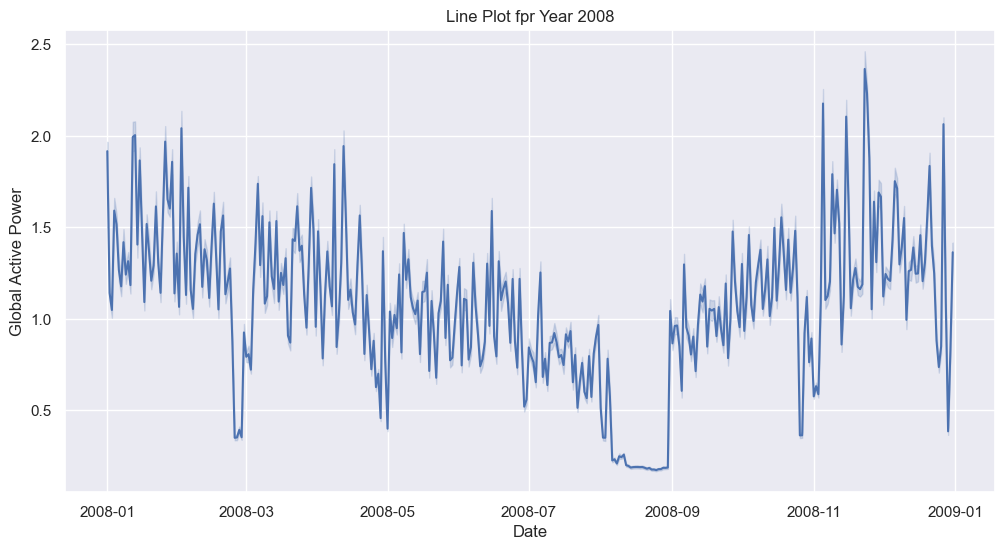

In [46]:
energy['Date'] = pd.to_datetime(energy['Date'], format='%d/%m/%Y')
plt.figure(figsize=(12, 6)) 
filtered_data = energy[(energy['Date'].dt.year == 2008)]
sns.set(style="darkgrid")
sns.lineplot(x='Date', y='Global_active_power', data=filtered_data)
plt.title('Line Plot fpr Year 2008')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.show()

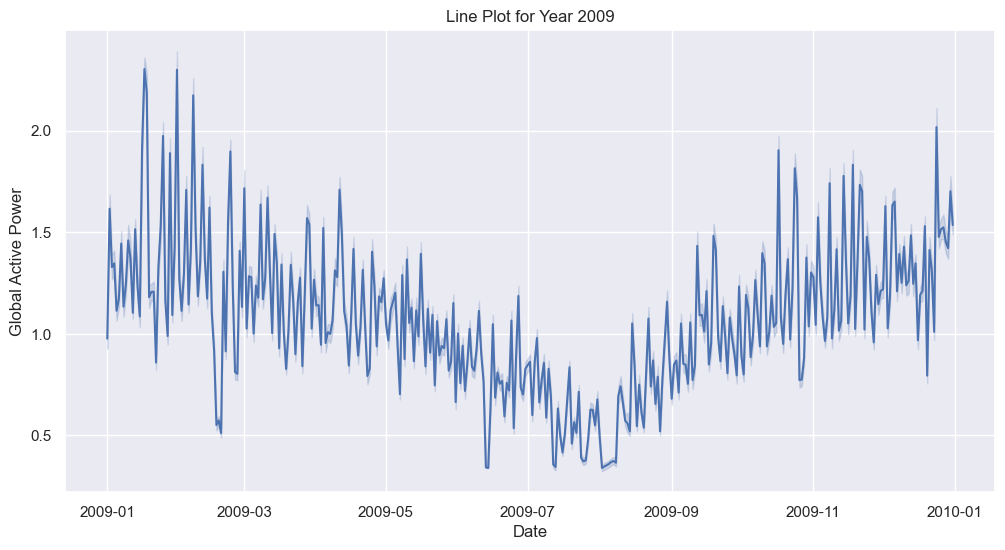

In [47]:
energy['Date'] = pd.to_datetime(energy['Date'], format='%d/%m/%Y')
plt.figure(figsize=(12, 6)) 
filtered_data = energy[(energy['Date'].dt.year == 2009)]
sns.set(style="darkgrid")
sns.lineplot(x='Date', y='Global_active_power', data=filtered_data)
plt.title('Line Plot for Year 2009')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.show()

# Scatter Plot

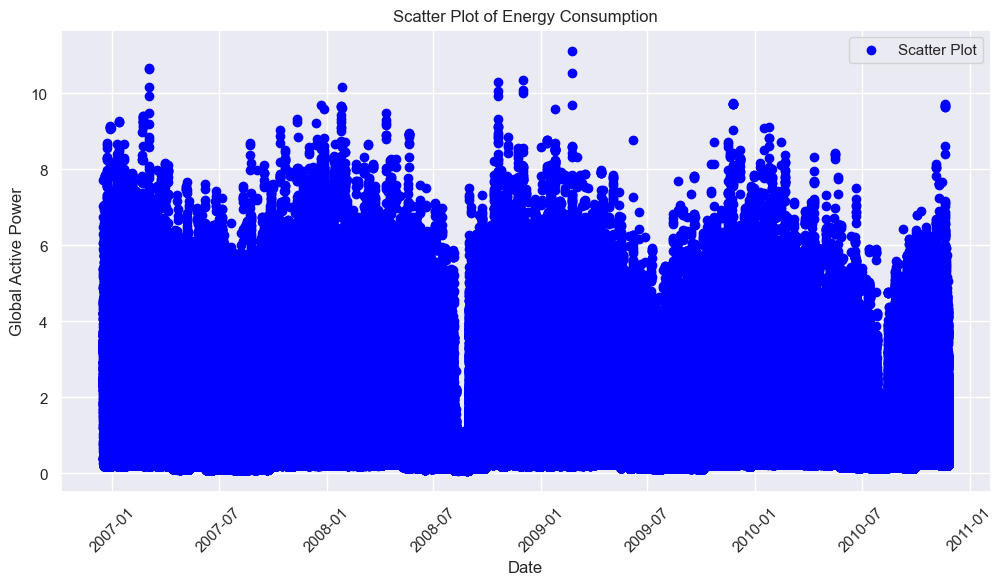

In [48]:
energy['Date'] = pd.to_datetime(energy['Date'])

# Extract the data
x = energy['Date']
y = energy['Global_active_power']

# Create a scatter plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.scatter(x, y, label='Scatter Plot', color='blue', marker='o')

# Customize the plot with labels and titles
plt.title('Scatter Plot of Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Global Active Power')

# Show the scatter plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Add a grid for reference
plt.legend()
plt.show()

# Noise

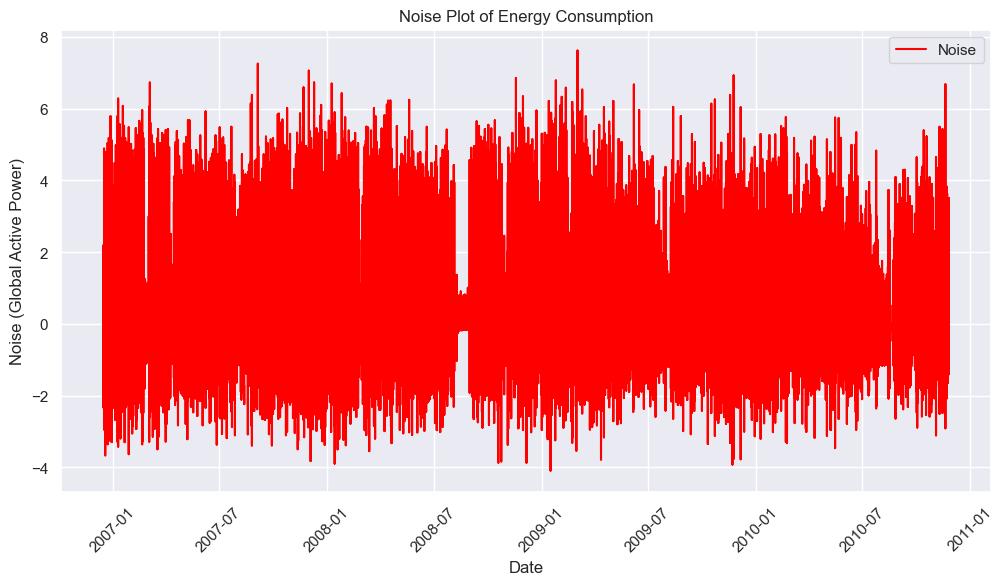

In [49]:
energy['Date'] = pd.to_datetime(energy['Date'])

# Extract the data
x = energy['Date']
y = energy['Global_active_power']

# Define the window size for the moving average (adjust as needed)
window_size = 50

# Calculate the moving average
smoothed_data = y.rolling(window=window_size).mean()

# Calculate the noise by subtracting the moving average from the original data
noise = y - smoothed_data

# Create a plot for the noise
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(x, noise, label='Noise', color='red')

# Customize the plot with labels and titles
plt.title('Noise Plot of Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Noise (Global Active Power)')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Add a grid for reference
plt.legend()
plt.show()

# Seasonality

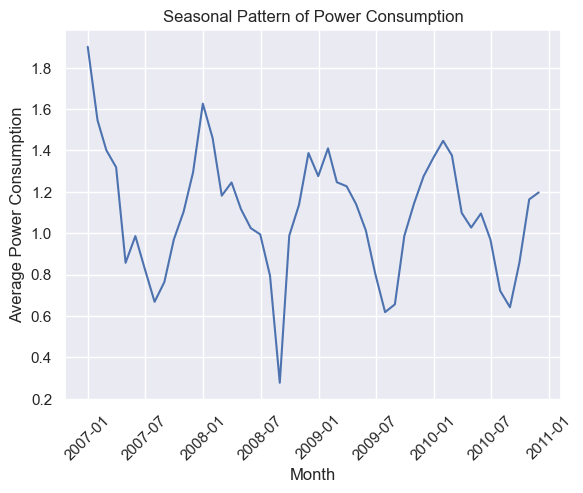

In [50]:
energy['Date'] = pd.to_datetime(energy['Date'])
energy.set_index('Date', inplace=True)

resampled_data = energy['Global_active_power'].resample('M').mean()

# Create a line plot to show the seasonal pattern
sns.set(style="darkgrid")
sns.lineplot(x=resampled_data.index, y=resampled_data)

plt.title('Seasonal Pattern of Power Consumption')
plt.xlabel('Month')
plt.ylabel('Average Power Consumption')
plt.xticks(rotation=45)

plt.show()

# Summarize power by month (mean, median, max)

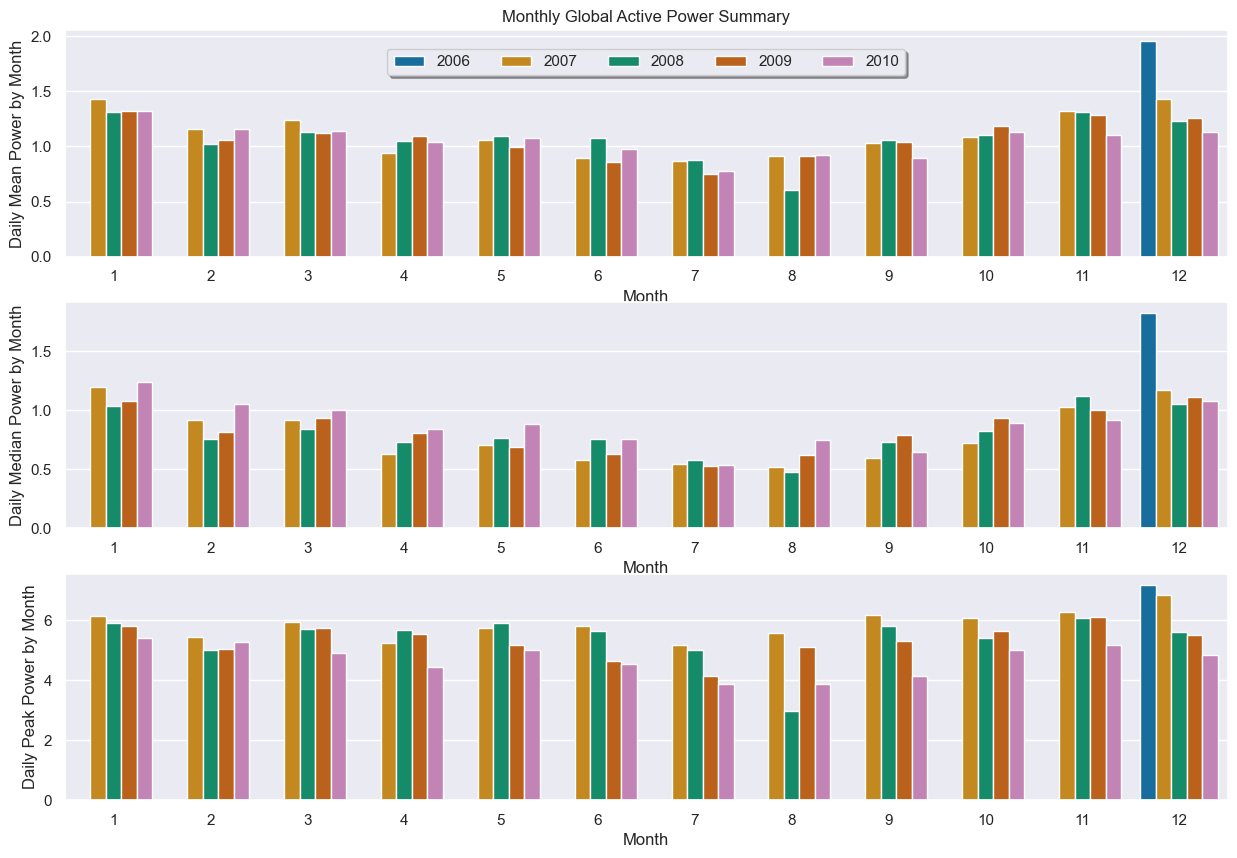

In [51]:
energy_monthly_summary = energy.groupby(
    by=['Year', 'Month', 'Date'],
    as_index=False
).agg(mean_active_power=('Global_active_power', 'mean'),
       median_active_power=('Global_active_power', 'median'),
       max_active_power=('Global_active_power', 'max'))

energy_monthly_summary.head()

# Create subplots
sns.set_style("darkgrid")
f, axes = plt.subplots(3, figsize=(15, 10), sharex=False)

# Monthly Mean subplot
mean = sns.barplot(x=energy_monthly_summary.Month,
            y=energy_monthly_summary.mean_active_power,
            hue=energy_monthly_summary.Year,
            palette="colorblind",
            ax=axes[0],
            ci=None)
mean.set_title('Monthly Global Active Power Summary')
mean.set_ylabel('Daily Mean Power by Month')
mean.legend_.remove()

# Monthly Median subplot
median = sns.barplot(x=energy_monthly_summary.Month,
            y=energy_monthly_summary.median_active_power,
            hue=energy_monthly_summary.Year,
            palette="colorblind",
            ax=axes[1],
            ci=None)
median.legend_.remove()
median.set_ylabel('Daily Median Power by Month')

# Monthly Peak subplot
max = sns.barplot(x=energy_monthly_summary.Month,
            y=energy_monthly_summary.max_active_power,
            hue=energy_monthly_summary.Year,
            palette="colorblind",
            ax=axes[2],
            ci=None) 
max.set_ylabel('Daily Peak Power by Month')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 3.35), shadow=True, ncol=5)

# Boxplot of Weekday Summary

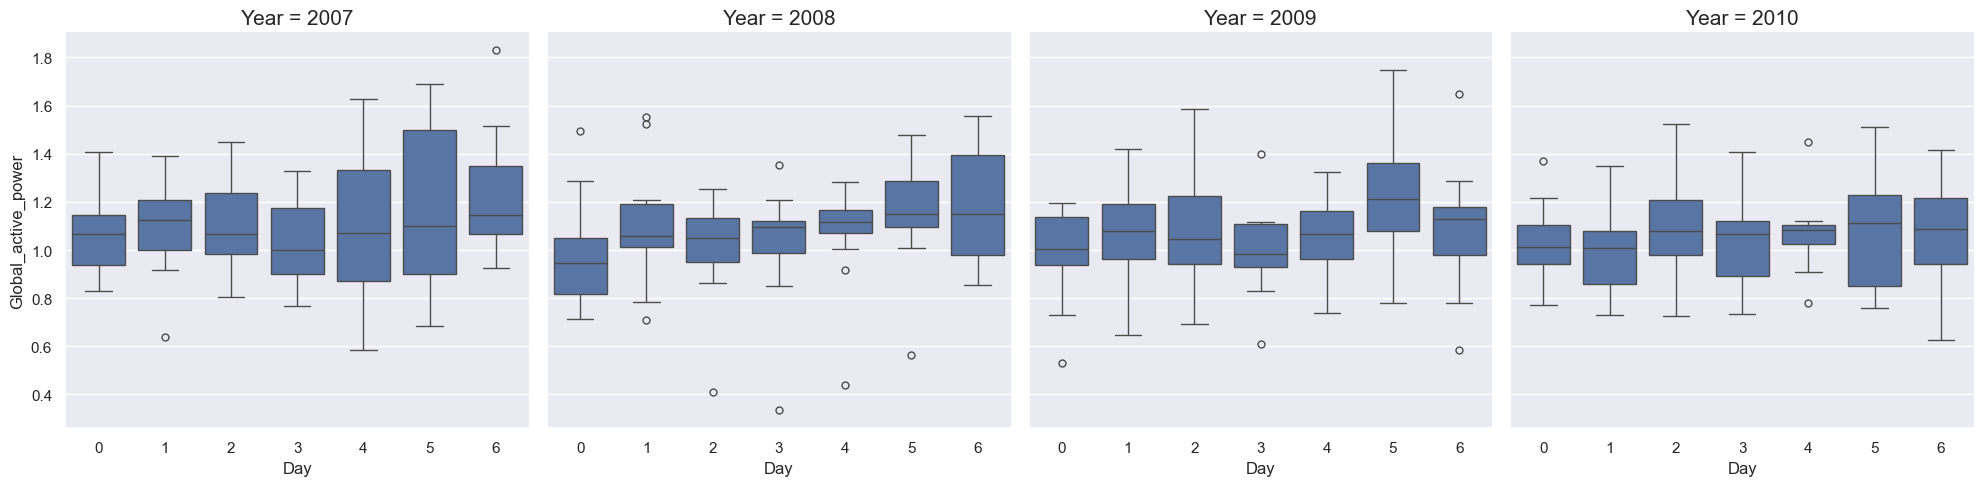

In [52]:
energy_weekday_summary = energy.groupby(by=['Year','Month','Day'], as_index=False)[['Global_active_power']].mean()

day_plot = sns.catplot(x="Day", y="Global_active_power", data=energy_weekday_summary.query("Year != 2006"), 
           kind="box",
           col="Year")
day_plot.set_titles(size = 15)

# Analyzing Trends

### Boxplot Hourly Average By Year

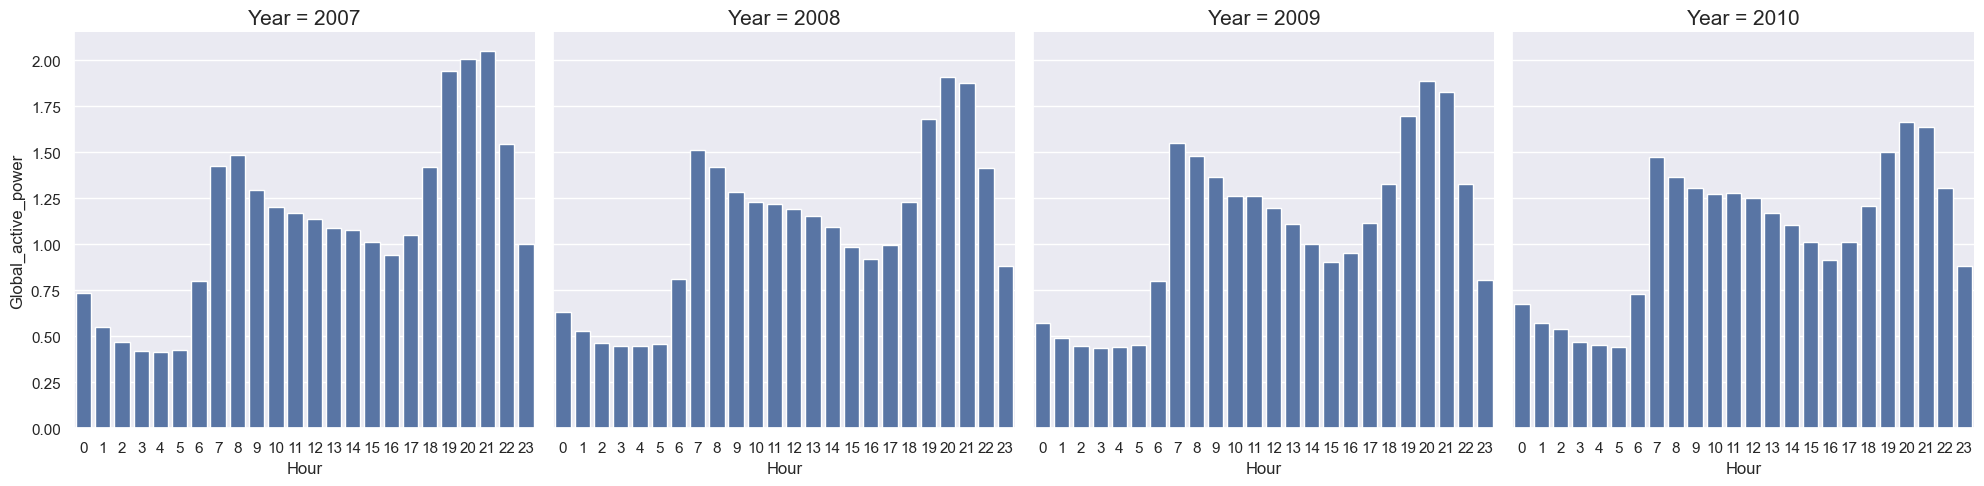

In [53]:
energy_hourly_summary = energy.groupby(by=['Year','Month','Day','Hour'], 
                                       as_index=False)[['Global_active_power']].mean()

hour_plot = sns.catplot(x="Hour", y="Global_active_power", data=energy_hourly_summary.query("Year != 2006"), 
           kind="bar",
           col="Year",
           ci=None)
hour_plot.set_titles(size = 15)

### Boxlot Hourly Average By Month

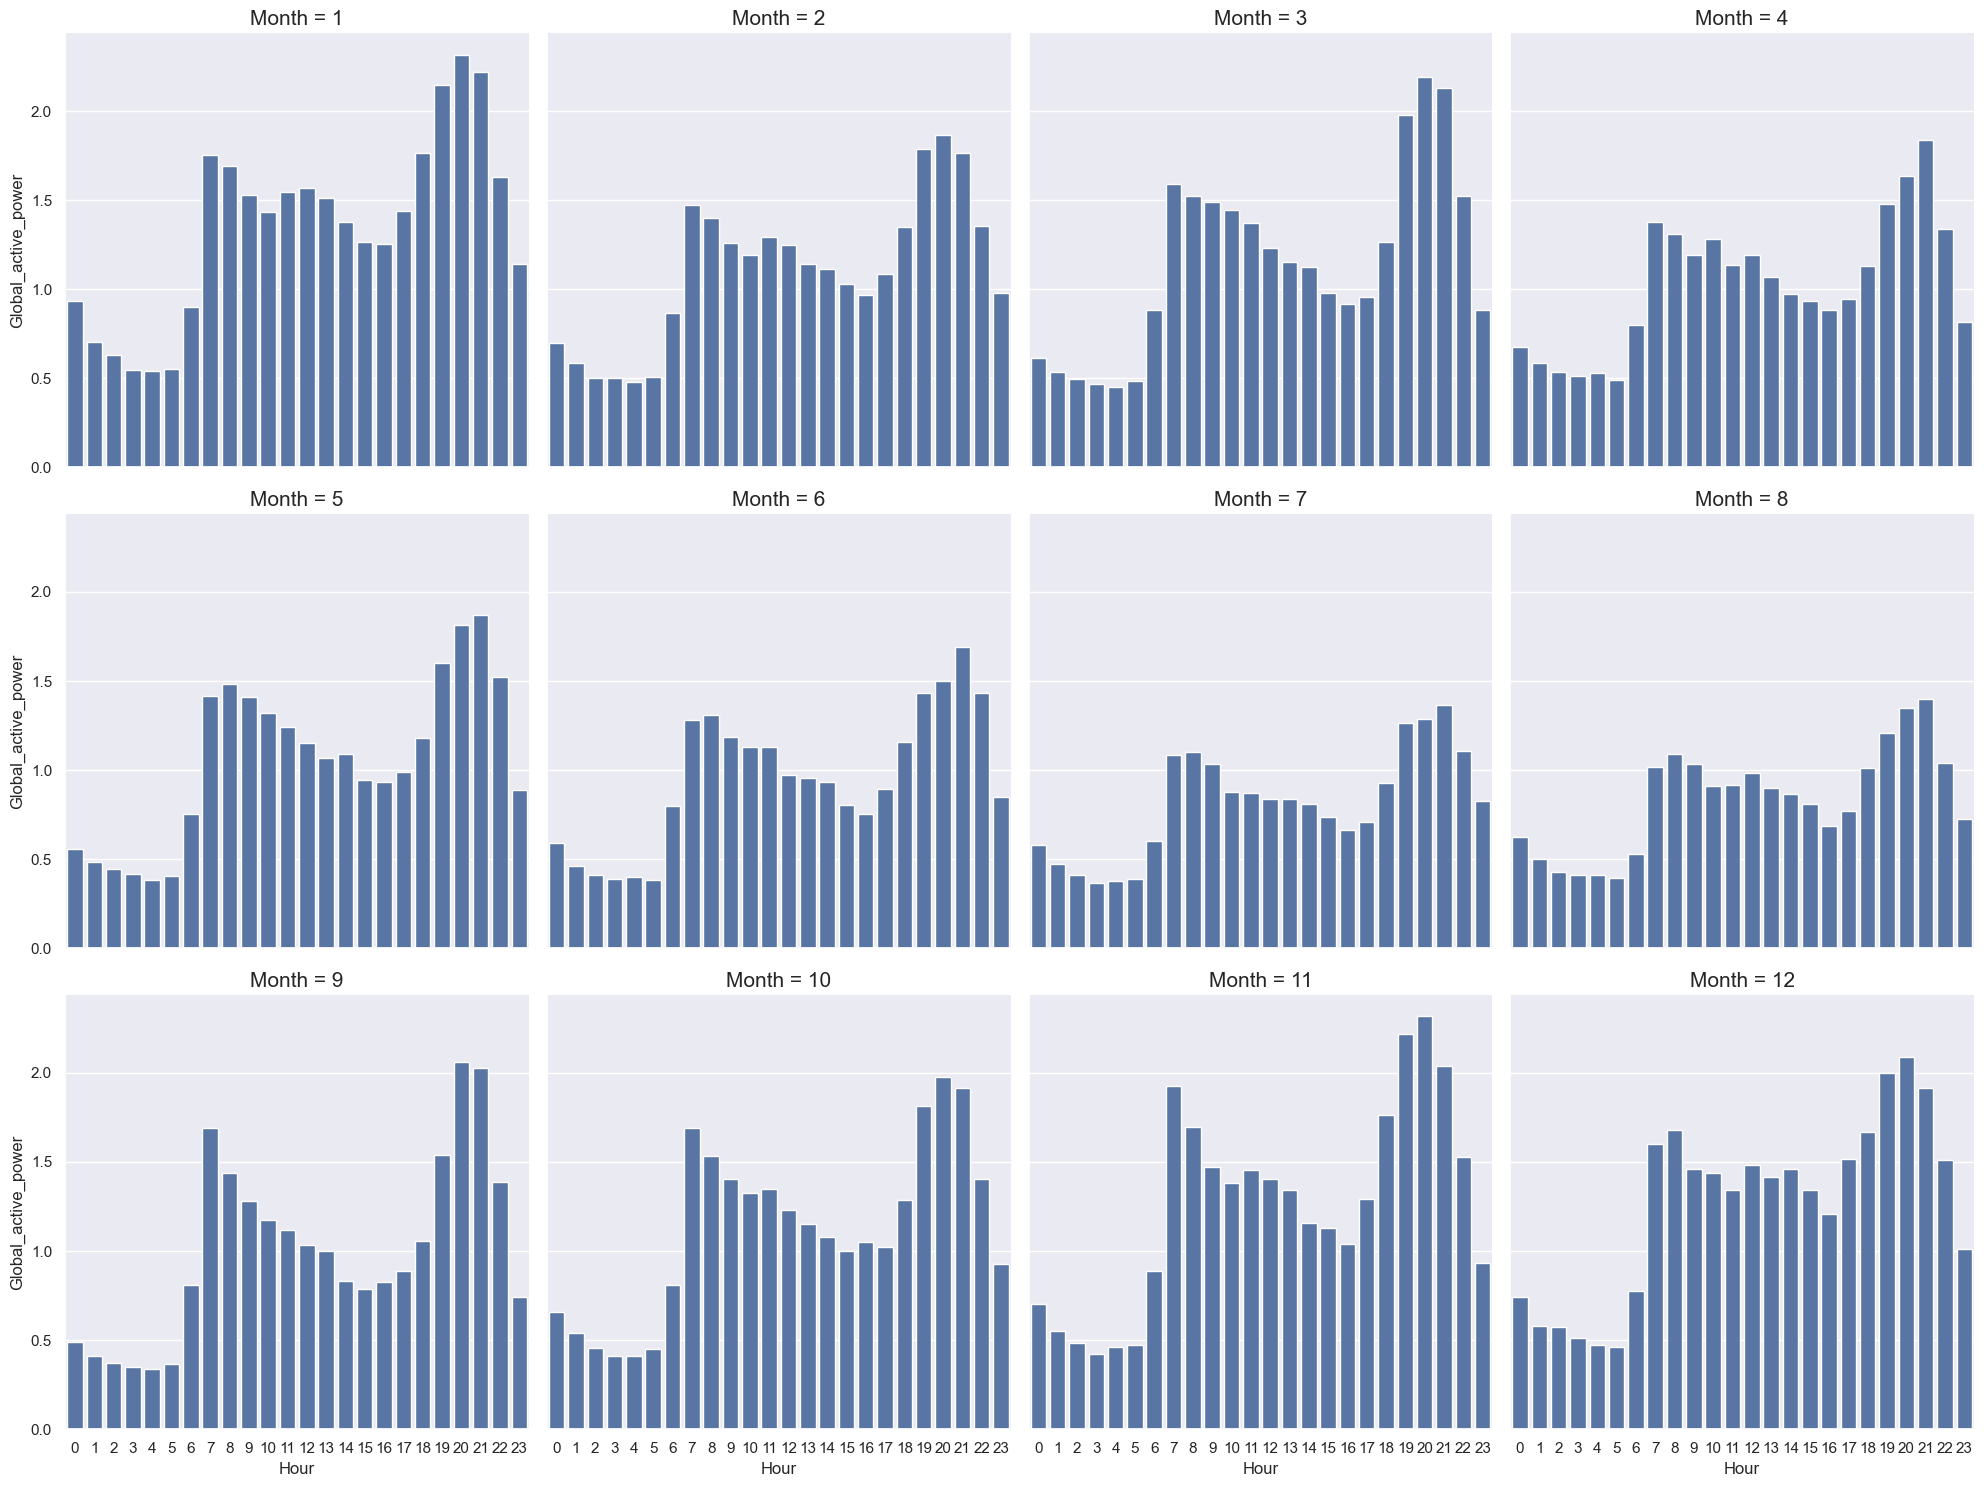

In [54]:
current_palette = sns.color_palette("Paired")

hour_plot2 = sns.catplot(x="Hour", y="Global_active_power", data=energy_hourly_summary.query("Year != 2006"), 
           kind="bar",
           col="Month",
           col_wrap = 4,
           ci=None)
hour_plot2.set_titles(size = 15)

# Visualization
 The visualization below shows a comprehensive view of the dataset. The plotly visual shows mean, median, and peak power values for all dates in the time series.

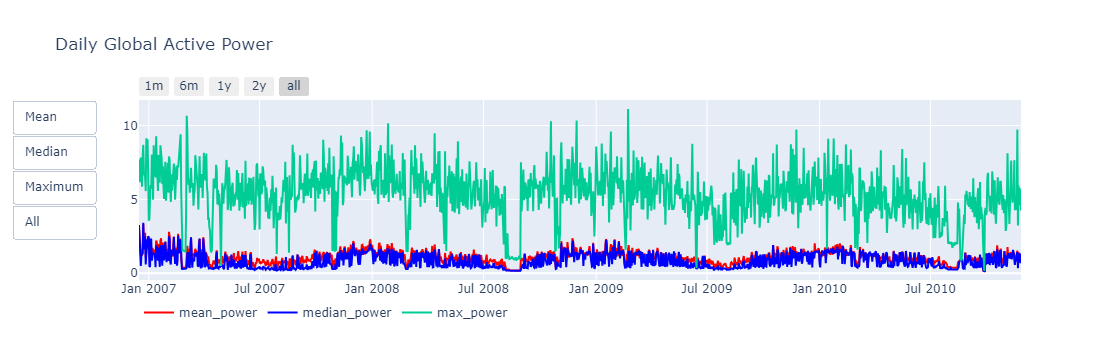

In [55]:
import plotly.graph_objs as go
from plotly.offline import iplot

# Assuming 'Date' is currently the index
energy.reset_index(inplace=True)

# Convert 'Date' to datetime
energy['Date'] = pd.to_datetime(energy['Date'])

energy_daily_summary = energy.groupby('Date', as_index=False).agg(
    mean_active_power=('Global_active_power', 'mean'),
    median_active_power=('Global_active_power', 'median'),
    max_active_power=('Global_active_power', 'max')
)

mean_power = go.Scatter(x=energy_daily_summary.Date,
                        y=energy_daily_summary.mean_active_power,
                        name='mean_power',
                        line=dict(color='red'))

median_power = go.Scatter(x=energy_daily_summary.Date,
                            y=energy_daily_summary.median_active_power,
                            name='median_power',
                            line=dict(color='blue'))

max_power = go.Scatter(x=energy_daily_summary.Date,
                       y=energy_daily_summary.max_active_power,
                       name='max_power')

updatemenus = list([
    dict(type="buttons",
         active=-1,
         buttons=list([
            dict(label='Mean',
                 method='update',
                 args=[{'visible': [True, False, False]},
                       {'title': 'Mean Global Active Power'}]),

            dict(label='Median',
                 method='update',
                 args=[{'visible': [False, True, False]},
                       {'title': 'Median Global Active Power'}]),

            dict(label='Maximum',
                 method='update',
                 args=[{'visible': [False, False, True]},
                       {'title': 'Maximum Global Active Power'}]),
            dict(label='All',
                 method='update',
                 args=[{'visible': [True, True, True]},
                       {'title': 'Overview of Global Active Power'}]),
        ]),
    )
])

data = [mean_power, median_power, max_power]

layout = dict(title='Daily Global Active Power',
              showlegend=True,
              updatemenus=updatemenus,
              legend=dict(orientation="h"),
              xaxis=dict(
                  rangeselector=dict(
                      buttons=list([
                          dict(count=1,
                               label='1m',
                               step='month',
                               stepmode='backward'),
                          dict(count=6,
                               label='6m',
                               step='month',
                               stepmode='backward'),
                          dict(count=1,
                               label='1y',
                               step='year',
                               stepmode='todate'),
                          dict(count=2,
                               label='2y',
                               step='year',
                               stepmode='backward'),
                          dict(step='all')
                      ]))))

# Create the plot dictionary after defining the layout
plot = dict(data=data, layout=layout)

# Use the 'iplot' function from 'plotly.offline' to display the plot
iplot(plot, filename='household_power_consumption')

# Data Pre-Processing 
Since we performed some data clean-up after importing the Household Power Consumption Dataset, the pre-processing step is limited. The code chunk below creates an hourly summary of mean power and then encodes 'Year' as categorical data using the Label Encoder.



In [56]:
from sklearn import preprocessing

#summarize by mean hourly energy
energy_hourly_summary = energy.groupby(
    by=['Year','Month','Day',"Hour"], as_index=False)[['Global_active_power']].mean()

#create the Label Encoder object
le = preprocessing.LabelEncoder()

#encode categorical data
energy_hourly_summary['Year'] = le.fit_transform(energy_hourly_summary['Year'])
energy_hourly_summary.head()

,Year,Month,Day,Hour,Global_active_power
0,0,12,0,0,0.637967
1,0,12,0,1,0.760033
2,0,12,0,2,0.361233
3,0,12,0,3,0.449950
4,0,12,0,4,0.802500


## Time Series Forecasting

### Forecasting with Linear Regression

#### Partition Series

The series are partitioned randomly with a 75% - 25% split between the train set and test set, respectively.

In [57]:
from sklearn.model_selection import train_test_split
x = energy_hourly_summary[['Year','Month','Day','Hour']]
y = energy_hourly_summary.Global_active_power
x_train,x_test,y_train,y_test=train_test_split(x, y, train_size=0.75, test_size = 0.25, random_state=1)

#### Apply Forecasting Methods

The linear regression method below uses the linear relationship between the x and y components of the training set to predict the y component of the test set.

In [58]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
model = lm.fit(x_train, y_train)
predictions=lm.predict(x_test)

#### Evaluate Performance
The scatter plot below shows the relationship between the actual test values and the predicted test values. It is evident from the equation of the regression line and the r-squared value that this is not a good model for the Global_active_power time series.

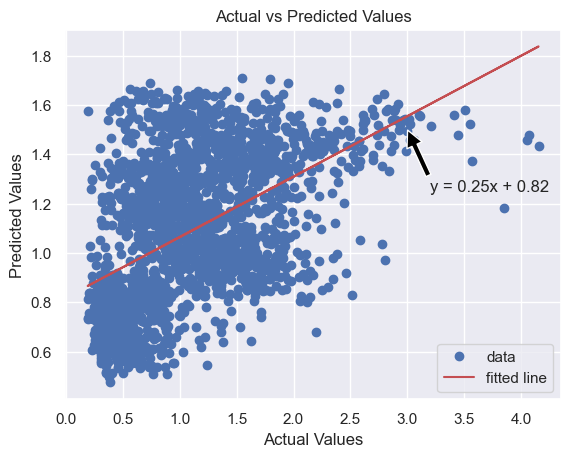

r-squared: 0.259503


In [59]:
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, predictions)

plt.plot(y_test, predictions, 'o', label='data')
plt.plot(y_test, intercept + slope*y_test, 'r', label='fitted line')
plt.legend()
plt.annotate(
'y = ' + str(round(slope,2)) + 'x' + ' + ' + str(round(intercept,2)), xy=(3, 1.5), xytext=(3.2, 1.25),
arrowprops=dict(facecolor='black', shrink=0.01))
plt.xlabel('Actual Values')
plt.title('Actual vs Predicted Values')
plt.ylabel('Predicted Values')
plt.show()
print("r-squared: %f" % r_value**2)

### Forecasting with SARIMAX

Seasonal AutoRegressive Integrated Moving Average (SARIMAX) is ideal for forecasting univariate time series data containing seasonal trends.



#### Partition Series

The series are partitioned based on year, with 2006-2009 in the train set and 2010 in the test set.

In [60]:
indexed_engery = energy[['Date_Time','Global_active_power', 'Year', 'Month']].set_index('Date_Time');
train = indexed_engery[indexed_engery['Year'] < 2010] #train set is years 2006 - 2009
test = indexed_engery[indexed_engery['Year'] == 2010] #test set is year 2010

#### Apply Forecasting Methods

For this model, we apply SARIMA on a weekly summary of the Global_active_power. I attempted to use days, however the processing time was too long.

In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
train_monthly=train[['Global_active_power']].resample('W').mean()
mod = SARIMAX(train_monthly, order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 50), #50 = number of weeks that we are forcasting
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

In [62]:
results.forecast()

2010-01-10    1.021018
Freq: W-SUN, dtype: float64

To extract forecasts, we indicate the date range that we are forecasting (most of 2010) in the .predict function below. The start and end indices of this function require exact values that are based on the seasonal_order specified in the SARIMA function.

In [63]:
predictions = results.predict(start='2010-01-03', end='2010-12-19')

Evaluate Performance
To evaluate the performance of the SARIMA model, we plot the distributions of predicted versus actual weekly power values in 2010. It seems like the distributions share a similar center but there are noticible differences in the shapes of the distributions.

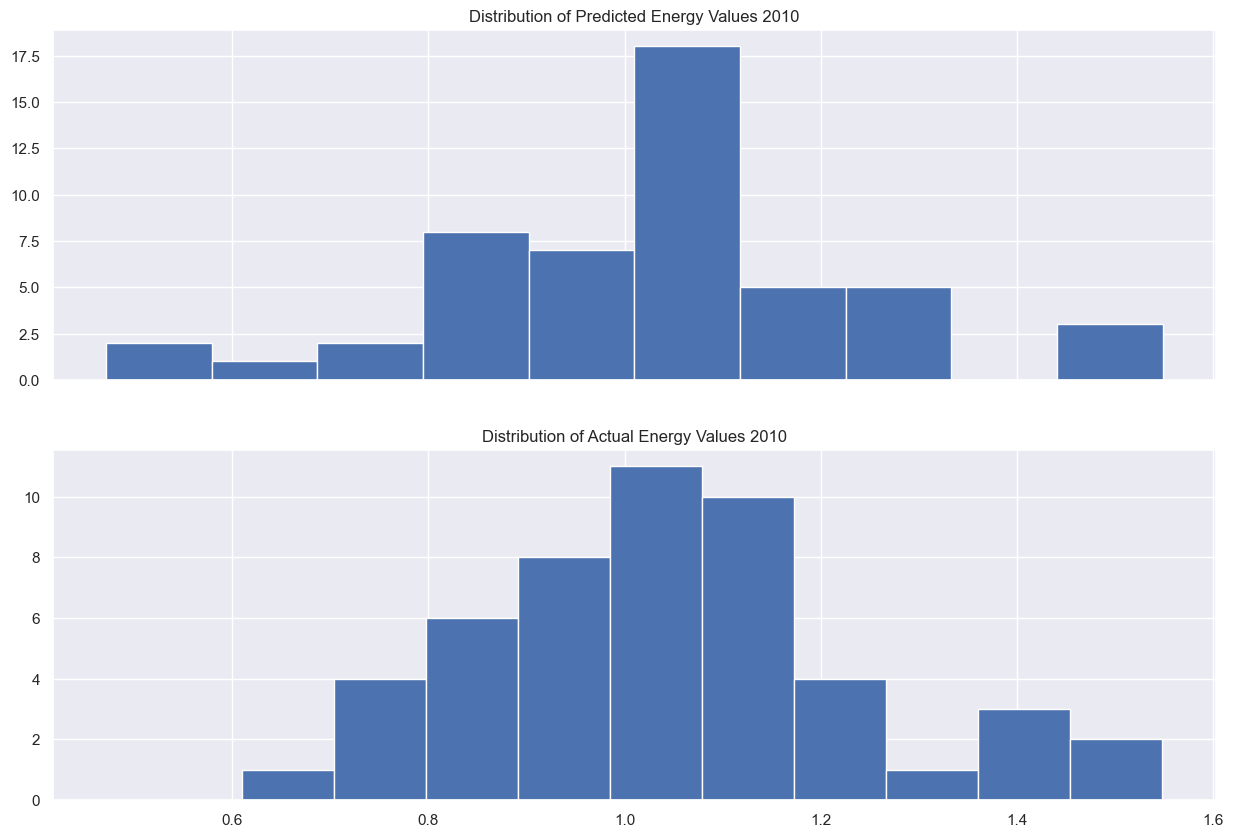

In [64]:
# predictions.index
f, axes = plt.subplots(2, figsize=(15, 10), sharex=True)
axes[0].hist(predictions.values, bins=10)
axes[0].set_title("Distribution of Predicted Energy Values 2010")
axes[1].hist((test[['Global_active_power']].resample('W').mean().values), bins=10)
axes[1].set_title("Distribution of Actual Energy Values 2010")
plt.show()

**Actual versus Predicted Values**

In [65]:
#merge on Date_Time
test[['Global_active_power']].resample('W').mean().reset_index()
prediction = pd.DataFrame(predictions).reset_index()
prediction.columns = ['Date_Time','Global_active_power']

res = pd.merge(test[['Global_active_power']].resample('W').mean(), 
               prediction, 
               how='left', 
               on='Date_Time')

res.columns = ['Date_Time','actual','predictions']
res.insert(3, 'residuals', res['actual'] - res['predictions']) #residuals
res.head()

,Date_Time,actual,predictions,residuals
0,2010-01-03,0.976101,1.512256,-0.536155
1,2010-01-10,0.920572,1.021018,-0.100446
2,2010-01-17,1.451530,1.305795,0.145735
3,2010-01-24,1.535291,1.039394,0.495897
4,2010-01-31,1.548028,0.853603,0.694425


Upon looking at the plot of actual versus predicted weekly Global_active_power, we see that the SARIMA predictions were close to the actual values. The plot of residuals shows that the difference between actuals and predicted values may have a pattern: mostly positive residuals in the first half of 2010, and mostly negative residuals in the latter half of 2010. Using the residuals, we calculate a Mean Squared Error (MSE) of 0.0532.

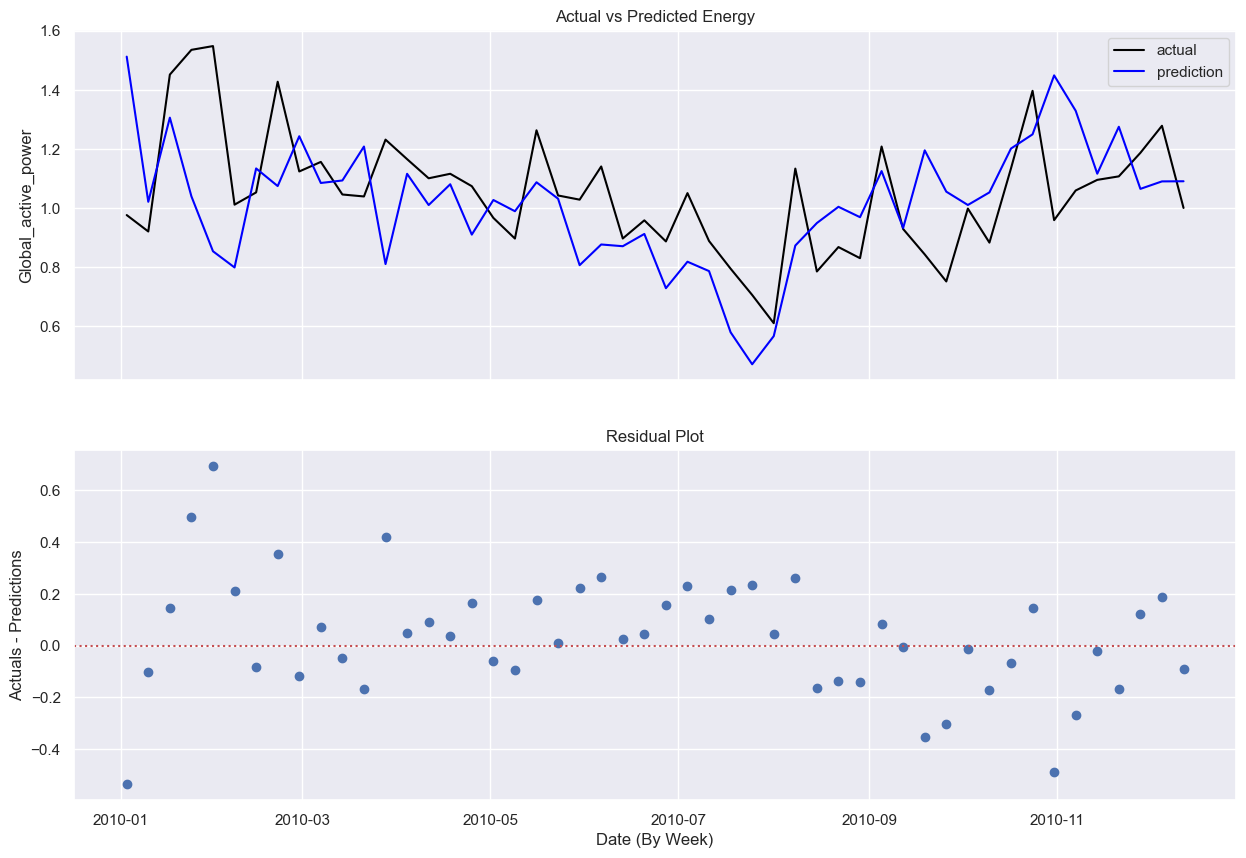

MSE =  0.053158924373325575


In [66]:
f, axes = plt.subplots(2, figsize=(15, 10), sharex=True)

#plot of actual vs predictions
axes[0].plot(res['Date_Time'],res['actual'], color='black', label='actual')
axes[0].plot(res['Date_Time'],res['predictions'], color='blue', label='prediction')
axes[0].set_title('Actual vs Predicted Energy')
axes[0].set_ylabel('Global_active_power')
axes[0].legend()

#plot of actual - predictions
axes[1].scatter(res['Date_Time'],(res['actual'] - res['predictions']))
axes[1].set_title('Residual Plot')
axes[1].set_xlabel('Date (By Week)')
axes[1].set_ylabel('Actuals - Predictions')
axes[1].axhline(y=0, color='r', linestyle=':')

plt.show()

#MSE
print("MSE = ", np.mean(res['residuals']**2)) #MSE

### Forecasting with Prophet
Prophet is a forecasting method created by Facebook that is used for seasonal time series. Rather than supplying weekly power averages, we can train this model using daily power averages.



#### Partition Series
This step creates the train and test datasets, each containing a date and the mean Global_active_power for that date. Similarly to the SARIMA model, I partitioned the train / test datasets by year.

In [67]:
train_2 = train.resample('D').mean().reset_index()
train_2 = train_2[['Date_Time', 'Global_active_power']]
train_2.columns = ['ds', 'y']
train_2.head()

,ds,y
0,2006-12-16,3.053475
1,2006-12-17,2.354486
2,2006-12-18,1.530435
3,2006-12-19,1.157079
4,2006-12-20,1.545658


In [68]:
test_2 = test.resample('D').mean().reset_index()
test_2 = test_2[['Date_Time', 'Global_active_power']]
test_2.columns = ['ds', 'y']
test_2.head()

,ds,y
0,2010-01-01,0.850175
1,2010-01-02,1.176235
2,2010-01-03,0.901894
3,2010-01-04,1.171833
4,2010-01-05,0.916776


Apply Forecasting Methods
This step creates trains the Prophet model; the fourier_order argument specifies how closely we want to capture the seasonality of the time series. A fourier_order of 10 translates to annual seasonality while a fourier_order of 3 translates to weekly seasonality. To avoid under- or over-fitting, I used a fourier_order of 8.

In [69]:
ph = Prophet(weekly_seasonality=False)
ph.add_seasonality(name='daily', period=1, fourier_order=8)
ph.fit(train_2)

23:15:33 - cmdstanpy - INFO - Chain [1] start processing
23:15:33 - cmdstanpy - INFO - Chain [1] done processing


This step creates a forecast for the next 365 days. The yhat_lower and yhat_upper values correspond to the default 80% confidence interval.

In [70]:
future = ph.make_future_dataframe(periods=365)
forecast = ph.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2006-12-16,1.473443,0.966475,1.937833
1,2006-12-17,1.483320,0.987112,1.988451
2,2006-12-18,1.493348,0.991201,2.006162
3,2006-12-19,1.503274,0.966335,1.972350
4,2006-12-20,1.512840,0.997817,2.025909


#### Evaluate Performance
To evaluate this model, we plot the Prophet prediction against the actual Global_active_power values for the entire time series. The actual values are plotted as points while the forecast is plotted as a line; the section with green points corresponds to the test set. It seems like the Prophet forecast model performed faily well, capturing the seasonal trends for the consumption time series.

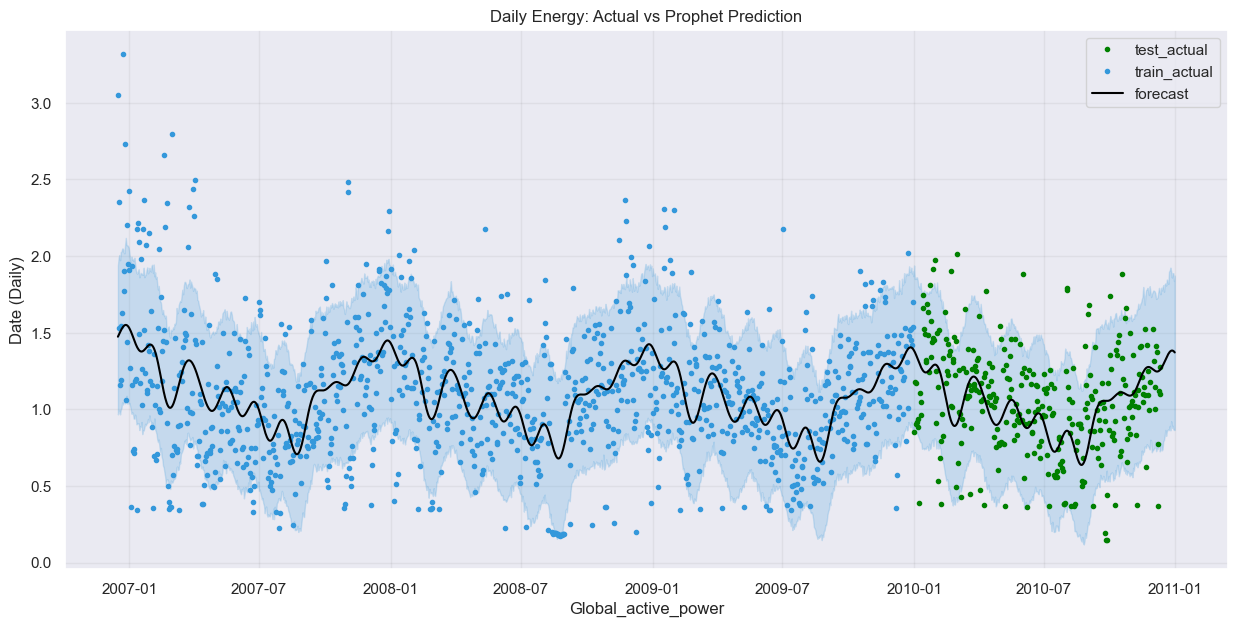

In [71]:
fig = plt.gcf()
fig.set_size_inches(15, 7)
plt.plot(test_2.ds, test_2.y, '.', color='green', label = "test_actual")
plt.plot(train_2.ds, train_2.y, '.', color='#3498db', label = "train_actual")
plt.plot(forecast.ds, forecast.yhat, color='black', label = "forecast")
plt.fill_between(forecast.ds, forecast.yhat_lower, forecast.yhat_upper, color=(52/255, 152/255, 219/255, 0.2))
plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.xlabel('Global_active_power')
plt.title('Daily Energy: Actual vs Prophet Prediction')
plt.ylabel('Date (Daily)')
plt.legend()
plt.show()